In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import copy
from google.colab import files

#Pre-Processing 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

#Models
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.linear_model import LinearRegression

#Kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern,ExpSineSquared,RationalQuadratic, ConstantKernel as C

#Scipy
import scipy
import scipy.optimize as opt
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from scipy.optimize import minimize
from scipy.stats import norm

#Feature Selection
!pip install mlxtend
!pip install mlxtend --upgrade --no-deps
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sns.set_style("whitegrid")

**Importing Data**

In [ ]:
!git clone https://github.com/ihdavjar/clap_and_fling_resources.git

fatal: destination path 'clap_and_fling_resources' already exists and is not an empty directory.


In [ ]:
org_data=pd.read_csv("/content/clap_and_fling_resources/Average/AverageLift.csv")
org_data.drop([15,16,17,18,19],inplace=True)
org_data=org_data.round(2)
org_data

,Re,Overlap,AOA,COL
0,20.00,0.00,20.00,0.66
1,20.00,0.00,50.00,0.57
2,20.00,100.00,20.00,1.01
3,20.00,100.00,50.00,0.86
4,200.00,0.00,20.00,0.71
5,200.00,0.00,50.00,0.64
6,200.00,100.00,20.00,1.10
7,200.00,100.00,50.00,0.92
8,20.00,50.00,35.00,0.77
9,200.00,50.00,35.00,0.84


**Covariance Analysis**

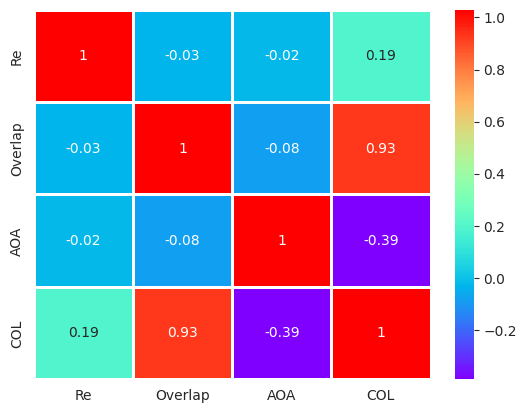

In [ ]:
scaler = preprocessing.StandardScaler()
l_col_new=org_data.columns
x_data_pd=pd.DataFrame(scaler.fit_transform(org_data),columns=l_col_new[0:len(l_col_new)])
sns.heatmap(x_data_pd.cov().round(2),cmap="rainbow",linecolor="white",linewidth=0.8,annot=True)
plt.show()

In [ ]:
temp_cov_mat=x_data_pd.cov().round(2)
temp_col=abs(np.array(temp_cov_mat['COL'])[0:3])

temp_cov_sum=sum(temp_col)

RE_per=temp_col[0]/temp_cov_sum
Overlap_per=temp_col[1]/temp_cov_sum
AOA_per=temp_col[2]/temp_cov_sum


print(RE_per,Overlap_per,AOA_per)

0.1258278145695364 0.6158940397350993 0.2582781456953642


**Plotting Bar Graph**

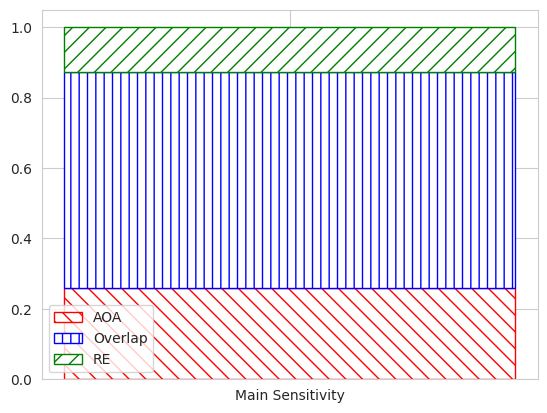

In [ ]:
plt.bar("Main Sensitivity", AOA_per, color="w",hatch='\\\\',edgecolor="r",width=0.1,label="AOA")
plt.bar("Main Sensitivity", Overlap_per, bottom=AOA_per, color="w",hatch='||',width=0.1,edgecolor="b",label="Overlap")
plt.bar("Main Sensitivity", RE_per, bottom=AOA_per+Overlap_per, color="w",hatch='//',width=0.1,edgecolor="g",label="RE")
plt.legend()
plt.show()

**Surrogate Modelling**

**Finding the Relation**

In [ ]:
org_data1=pd.read_csv("/content/clap_and_fling_resources/Average/Average_COL_All_Comb.csv")
org_data1

,A1,A2,A3,|A1|,|A2|,|A3|,(A1)^2,(A2)^2,(A3)^2,sinA1,...,cosA1,cosA2,cosA3,sin2A1,sin2A2,sin2A3,cos2A1,cos2A2,cos2A3,COL
0,20.000000,0.00000,20.000000,20.000000,0.00000,20.000000,400.000000,0.000000,400.000000,0.912945,...,0.408082,1.000000,0.408082,0.745113,0.000000,0.745113,-0.666938,1.000000,-0.666938,0.660017
1,20.000000,0.00000,50.000000,20.000000,0.00000,50.000000,400.000000,0.000000,2500.000000,0.912945,...,0.408082,1.000000,0.964966,0.745113,0.000000,-0.506366,-0.666938,1.000000,0.862319,0.566046
2,20.000000,100.00000,20.000000,20.000000,100.00000,20.000000,400.000000,10000.000000,400.000000,0.912945,...,0.408082,0.862319,0.408082,0.745113,-0.873297,0.745113,-0.666938,0.487188,-0.666938,1.007325
3,20.000000,100.00000,50.000000,20.000000,100.00000,50.000000,400.000000,10000.000000,2500.000000,0.912945,...,0.408082,0.862319,0.964966,0.745113,-0.873297,-0.506366,-0.666938,0.487188,0.862319,0.863892
4,200.000000,0.00000,20.000000,200.000000,0.00000,20.000000,40000.000000,0.000000,400.000000,-0.873297,...,0.487188,1.000000,0.408082,-0.850919,0.000000,0.745113,-0.525296,1.000000,-0.666938,0.709278
5,200.000000,0.00000,50.000000,200.000000,0.00000,50.000000,40000.000000,0.000000,2500.000000,-0.873297,...,0.487188,1.000000,0.964966,-0.850919,0.000000,-0.506366,-0.525296,1.000000,0.862319,0.637506
6,200.000000,100.00000,20.000000,200.000000,100.00000,20.000000,40000.000000,10000.000000,400.000000,-0.873297,...,0.487188,0.862319,0.408082,-0.850919,-0.873297,0.745113,-0.525296,0.487188,-0.666938,1.104816
7,200.000000,100.00000,50.000000,200.000000,100.00000,50.000000,40000.000000,10000.000000,2500.000000,-0.873297,...,0.487188,0.862319,0.964966,-0.850919,-0.873297,-0.506366,-0.525296,0.487188,0.862319,0.923330
8,20.000000,50.00000,35.000000,20.000000,50.00000,35.000000,400.000000,2500.000000,1225.000000,0.912945,...,0.408082,0.964966,-0.903692,0.745113,-0.506366,0.773891,-0.666938,0.862319,0.633319,0.766160
9,200.000000,50.00000,35.000000,200.000000,50.00000,35.000000,40000.000000,2500.000000,1225.000000,-0.873297,...,0.487188,0.964966,-0.903692,-0.850919,-0.506366,0.773891,-0.525296,0.862319,0.633319,0.837810


size of non transformed features:  (45, 21)
size of transformed features:  (45, 252)
['A1', 'A2', 'A3', '|A1|', '|A2|', '|A3|', '(A1)^2', '(A2)^2', '(A3)^2', 'sinA1', 'sinA2', 'sinA3', 'cosA1', 'cosA2', 'cosA3', 'sin2A1', 'sin2A2', 'sin2A3', 'cos2A1', 'cos2A2', 'cos2A3']
Size of new columns size: 252
['A1', 'A2', 'A3', '|A1|', '|A2|', '|A3|', '(A1)^2', '(A2)^2', '(A3)^2', 'sinA1', 'sinA2', 'sinA3', 'cosA1', 'cosA2', 'cosA3', 'sin2A1', 'sin2A2', 'sin2A3', 'cos2A1', 'cos2A2', 'cos2A3', 'A1^2', 'A1 A2', 'A1 A3', 'A1 |A1|', 'A1 |A2|', 'A1 |A3|', 'A1 (A1)^2', 'A1 (A2)^2', 'A1 (A3)^2', 'A1 sinA1', 'A1 sinA2', 'A1 sinA3', 'A1 cosA1', 'A1 cosA2', 'A1 cosA3', 'A1 sin2A1', 'A1 sin2A2', 'A1 sin2A3', 'A1 cos2A1', 'A1 cos2A2', 'A1 cos2A3', 'A2^2', 'A2 A3', 'A2 |A1|', 'A2 |A2|', 'A2 |A3|', 'A2 (A1)^2', 'A2 (A2)^2', 'A2 (A3)^2', 'A2 sinA1', 'A2 sinA2', 'A2 sinA3', 'A2 cosA1', 'A2 cosA2', 'A2 cosA3', 'A2 sin2A1', 'A2 sin2A2', 'A2 sin2A3', 'A2 cos2A1', 'A2 cos2A2', 'A2 cos2A3', 'A3^2', 'A3 |A1|', 'A3 |

[]

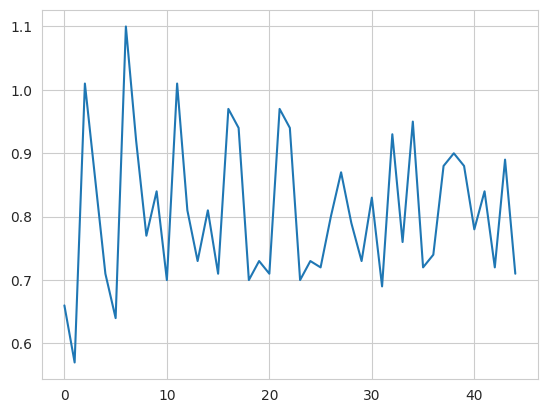

In [ ]:
numpy_data=np.array(org_data1).round(2)
x_data=numpy_data[:,0:len(numpy_data[0])-1]
y_data=numpy_data[:,len(numpy_data[0])-1]


print("size of non transformed features: ",np.shape(x_data)) #removing the coefficient of lift

#Taking Polynomial Data
poly = PolynomialFeatures(degree=2, include_bias=False)

x_data=poly.fit_transform(x_data)
print("size of transformed features: ",np.shape(x_data))

#Names of features
col_names=list(org_data1.columns[0:len(numpy_data[0])-1])
print(col_names)

#After the transformation names of variables
poly_names=list(poly.get_feature_names_out(col_names))
print("Size of new columns size:",len(poly_names))
poly_names.append("COL")

print(poly_names)
transformed_data=np.c_[x_data,y_data]
transformed_data_pd=pd.DataFrame(transformed_data,columns=poly_names)
plt.plot(y_data)
plt.plot()

In [ ]:
transformed_data_pd

,A1,A2,A3,|A1|,|A2|,|A3|,(A1)^2,(A2)^2,(A3)^2,sinA1,...,sin2A3 cos2A1,sin2A3 cos2A2,sin2A3 cos2A3,cos2A1^2,cos2A1 cos2A2,cos2A1 cos2A3,cos2A2^2,cos2A2 cos2A3,cos2A3^2,COL
0,20.00,0.00,20.00,20.00,0.00,20.00,400.00,0.00,400.00,0.91,...,-0.5025,0.7500,-0.5025,0.4489,-0.6700,0.4489,1.0000,-0.6700,0.4489,0.66
1,20.00,0.00,50.00,20.00,0.00,50.00,400.00,0.00,2500.00,0.91,...,0.3417,-0.5100,-0.4386,0.4489,-0.6700,-0.5762,1.0000,0.8600,0.7396,0.57
2,20.00,100.00,20.00,20.00,100.00,20.00,400.00,10000.00,400.00,0.91,...,-0.5025,0.3675,-0.5025,0.4489,-0.3283,0.4489,0.2401,-0.3283,0.4489,1.01
3,20.00,100.00,50.00,20.00,100.00,50.00,400.00,10000.00,2500.00,0.91,...,0.3417,-0.2499,-0.4386,0.4489,-0.3283,-0.5762,0.2401,0.4214,0.7396,0.86
4,200.00,0.00,20.00,200.00,0.00,20.00,40000.00,0.00,400.00,-0.87,...,-0.3975,0.7500,-0.5025,0.2809,-0.5300,0.3551,1.0000,-0.6700,0.4489,0.71
5,200.00,0.00,50.00,200.00,0.00,50.00,40000.00,0.00,2500.00,-0.87,...,0.2703,-0.5100,-0.4386,0.2809,-0.5300,-0.4558,1.0000,0.8600,0.7396,0.64
6,200.00,100.00,20.00,200.00,100.00,20.00,40000.00,10000.00,400.00,-0.87,...,-0.3975,0.3675,-0.5025,0.2809,-0.2597,0.3551,0.2401,-0.3283,0.4489,1.10
7,200.00,100.00,50.00,200.00,100.00,50.00,40000.00,10000.00,2500.00,-0.87,...,0.2703,-0.2499,-0.4386,0.2809,-0.2597,-0.4558,0.2401,0.4214,0.7396,0.92
8,20.00,50.00,35.00,20.00,50.00,35.00,400.00,2500.00,1225.00,0.91,...,-0.5159,0.6622,0.4851,0.4489,-0.5762,-0.4221,0.7396,0.5418,0.3969,0.77
9,200.00,50.00,35.00,200.00,50.00,35.00,40000.00,2500.00,1225.00,-0.87,...,-0.4081,0.6622,0.4851,0.2809,-0.4558,-0.3339,0.7396,0.5418,0.3969,0.84


['A1', '(A2)^2', 'cosA3', 'A1 A2', 'A1 (A2)^2', 'A1 sin2A1', 'A2 (A3)^2', 'A3 (A2)^2', 'A3 (A3)^2', '|A1| (A1)^2', '|A1| sin2A1', '(A2)^2 cosA2', '(A3)^2^2', 'sinA2 sin2A2', 'sinA2 cos2A2', 'sinA3 cos2A2', 'sin2A3 cos2A3', 'cos2A1^2']
CV Score for s:
0.9980827192087421


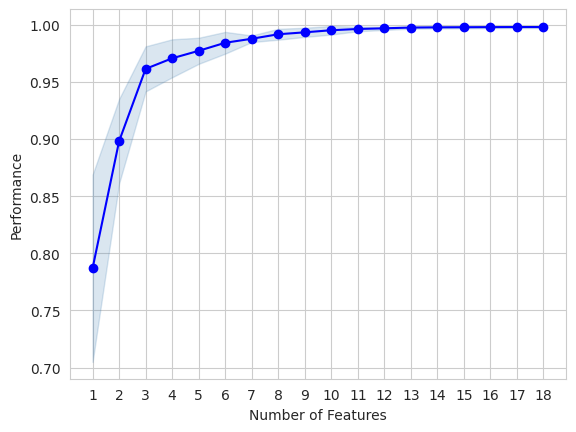

In [ ]:
model=LinearRegression()
sfs=SFS(model,k_features=18,forward=True,floating=False,cv=5)
sfs.fit(x_data,y_data)

temp_index=sfs.k_feature_idx_
temp_cols=poly_names
chosen_features=[]
for i in range(len(temp_index)):
  chosen_features.append(temp_cols[temp_index[i]])

print(chosen_features)


print('CV Score for s:')
print(sfs.k_score_)

fig1=plot_sfs(sfs.get_metric_dict())
plt.show()

In [ ]:
org_data_np=np.array(org_data)
x_data=org_data_np[:,0:3]
y_data=org_data_np[:,3]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33,shuffle=False, random_state=42)
print(len(x_train))

26


In [ ]:
lbound = 1e-5
rbound = 1e5

n_restarts = 50

n_features = 3 

kernel = C(1.0, (lbound,rbound)) *Matern()
kernel = C(1.0, (lbound,rbound)) *ExpSineSquared()
kernel = C(1.0, (lbound,rbound)) *RationalQuadratic()
kernel = C(1.0, (lbound,rbound)) *RBF()
kernel=C(1.0, (lbound,rbound)) * RBF(n_features*[n_features], (lbound,rbound))  + WhiteKernel()

# kernel=RBF()
print(kernel)
model = GPR(kernel=kernel, n_restarts_optimizer=n_restarts)

model.fit(x_train, y_train)

test_model, sigma2_pred = model.predict(x_test, return_std=True)
print(model.kernel_)

1**2 * RBF(length_scale=[3, 3, 3]) + WhiteKernel(noise_level=1)
0.855**2 * RBF(length_scale=[1.98e+03, 176, 42]) + WhiteKernel(noise_level=1.58e-05)


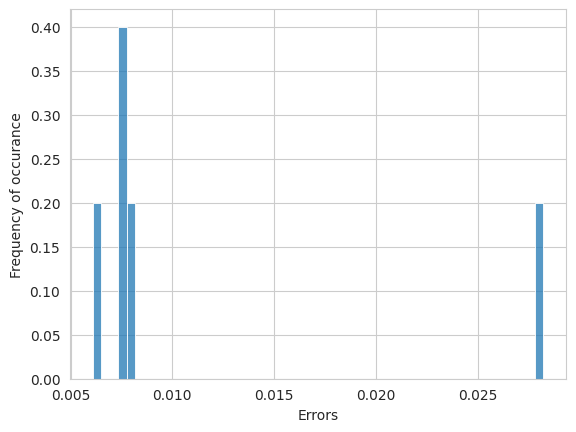

In [ ]:
model = GPR(kernel=kernel, n_restarts_optimizer=n_restarts)
errors=[]
for i in range(5):
  l=cross_val_score(model, x_data, y_data, cv=5,scoring="neg_mean_absolute_error")
  l=-1*l
  errors.append(l)

errors=np.array(errors)
errors=errors.flatten()

sns.histplot(errors,stat='probability')
plt.ylabel("Frequency of occurance")
plt.xlabel("Errors")
plt.show()

In [ ]:
model = GPR(kernel=kernel, n_restarts_optimizer=n_restarts)
model.fit(x_train, y_train)
# Compute baseline score
baseline_score = model.score(x_test, y_test)

# Perform feature sensitivity analysis
feature_importance = {}
for feature_idx in range(x_data.shape[1]):
    # Make a copy of the test set
    X_test_permuted = x_test.copy()

    # Permute the values of the current feature
    permuted_feature = np.random.permutation(x_test[:, feature_idx])
    X_test_permuted[:, feature_idx] = permuted_feature

    # Compute the score with permuted feature
    permuted_score = model.score(X_test_permuted, y_test)

    # Compute feature importance
    feature_importance[feature_idx] = baseline_score - permuted_score

# Calculate total importance
total_importance = sum(feature_importance.values())

# Calculate percentage importance
percentage_importance = {}
for feature_idx, importance in feature_importance.items():
    percentage_importance[feature_idx] = (importance / total_importance) * 100

# Sort the percentage importance values
sorted_importance = sorted(percentage_importance.items(), key=lambda x: x[1], reverse=True)

# Print percentage importance
for feature_idx, importance in sorted_importance:
    print(f"Feature {feature_idx+1}: Importance = {importance:.2f}%")


Feature 2: Importance = 89.54%
Feature 3: Importance = 7.44%
Feature 1: Importance = 3.02%


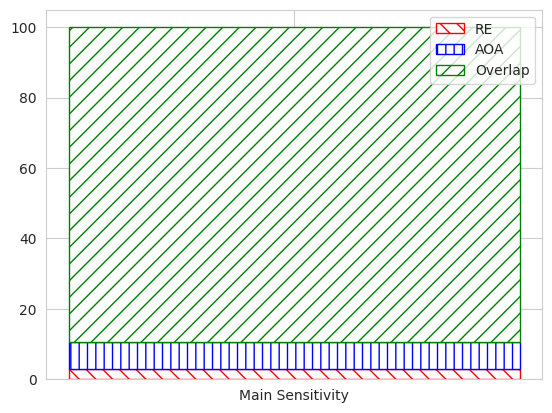

In [ ]:
sorted_importance
AOA_per=sorted_importance[1][1]
Overlap_per=sorted_importance[0][1]
RE_per=sorted_importance[2][1]

plt.bar("Main Sensitivity", RE_per, color="w",hatch='\\\\',edgecolor="r",width=0.1,label="RE")
plt.bar("Main Sensitivity", AOA_per, bottom=RE_per, color="w",hatch='||',width=0.1,edgecolor="b",label="AOA")
plt.bar("Main Sensitivity", Overlap_per, bottom=AOA_per+RE_per, color="w",hatch='//',width=0.1,edgecolor="g",label="Overlap")
plt.legend()
plt.show()

In [ ]:
model.score(x_test,y_test)

-85.864120722748

**Acquisition Function Modelling**

In [ ]:
def acquisition_function1(x_vec):
  x1,x2,x3=x_vec
  temp_mean, temp_sigma= model.predict([[x1,x2,x3]], return_std=True)

  temp=temp_mean+10*temp_sigma
  return -1*temp

def acquisition_function2(x_vec):
 
  # Using estimate from Gaussian surrogate instead of actual function for 
  # a new trial data point to avoid cost
  mean_y_new, sigma_y_new = model.predict(np.array([x_vec]), return_std=True)
  sigma_y_new = sigma_y_new.reshape(-1,1)
  if sigma_y_new == 0.0:
      return 0.0
  
  # Using estimates from Gaussian surrogate instead of actual function for 
  # entire prior distribution to avoid cost
  
  mean_y = model.predict(x_train)
  max_mean_y = np.max(mean_y)
  z = (mean_y_new - max_mean_y) / sigma_y_new
  exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
  
  return -1*exp_imp

def opt(model,x_train,n_iter=50):  #Minimising the negative of the acquisition function
    xo = np.array([30,30,30])
    bnds=[(20,200),(0,100),(20,50)]
    minimizer_kwargs = { "method": "L-BFGS-B","bounds":bnds }
    # return scipy.optimize.basinhopping(acquisition_function, xo,minimizer_kwargs=minimizer_kwargs,niter=50)#
    # return differential_evolution(acquisition_function, bnds).x
    x01=np.random.rand(1)*(200-20)+20
    x02=np.random.rand(1)*(100-0)
    x03=np.random.rand(1)*(50-20)+20


    best_x=np.zeros((1,3))
    best_value=10
    #Using the minimiser many times
    for i in range(n_iter):
      x01=np.random.rand(1)*(200-20)+20
      x02=np.random.rand(1)*(100-0)
      x03=np.random.rand(1)*(50-20)+20
      result=basinhopping(acquisition_function1, [x01,x02,x03], niter=100,minimizer_kwargs=minimizer_kwargs,disp=False)
      # result = minimize(fun=acquisition_function,
      #                   x0=[x01,x02,x03],
      #                   bounds=bnds,
      #                   method='L-BFGS-B',
      #                   args=(model))
      
      if (best_value>result.fun):
        best_x=result.x
        best_value=result.fun

    # 
    optimal_solution = best_x

    print("Optimal solution:", optimal_solution)
    print("Optimal value:", best_value)  # Convert back to maximization

    return 
x_out=opt(model,x_train)




Optimal solution: [152.24228976  15.02828102  47.55259846]
Optimal value: -14.142135623730951


**Complete Implementation**

In [ ]:
class bayesopt:

  def __init__(self,acquisition_function="UCB",term_cond="LOSS",min_algo="basinhopping",par_lambda=1000,beta=1):
    self.acq_fun=acquisition_function
    self.min_algo=min_algo
    self.par_lambda=par_lambda
    self.term_cond=term_cond
    self.beta=beta

  #Pre-Processing to bring each of the feature in the same scale
  def preprocessing(self,x_data,y_data):
    #For MinMax Normalisation
    min_values=[]
    max_values=[]

    self.org_data=copy.deepcopy(x_data)

    #Storing the max and min values
    self.maxes=max_values
    self.minis=min_values
    
    temp_x=copy.deepcopy(x_data)

    for i in range(len(x_data[0])):
      min_values.append(min(x_data[:,i]))
      max_values.append(max(x_data[:,i]))
    
    for i in range(len(x_data[0])):
      temp_x[:,i]=(temp_x[:,i]-min_values[i])/(max_values[i]-min_values[i])
    
    #Rounding to 2 Decimal points
    temp_x=temp_x.round(2)
    
    self.x_data_minmax=copy.deepcopy(temp_x)

    #Dividing into Train and Test Data
    x_train, x_test, y_train, y_test = train_test_split(temp_x, y_data, test_size=0.33,shuffle=False)

    self.x_train=x_train
    self.x_test=x_test
    self.y_train=y_train
    self.y_test=y_test

  #This will be called for making a initial guess of the function
  def surrogate_modelling(self,x_train,y_train,kernel="Default",n_restarts = 50,lbound = 1e-5,rbound = 1e5):  #Pass kernel as a function

    n_features = len(x_train[0]) # Actually determined elsewhere in the code
    
    if (kernel=="Default"):
      self.kernel=C(1.0, (lbound,rbound)) * RBF(n_features*[n_features], (lbound,rbound))  + WhiteKernel()
    else:
      self.kernel=kernel

    kernel=self.kernel
    print("Initial Kernel is: ",kernel)
    model = GPR(kernel=kernel, n_restarts_optimizer=n_restarts)
    model.fit(x_train, y_train)
    
    self.gp_model=model
    print("Optimised Kernel using Log-Marginal-Likelihood is:",model.kernel_)
  
  def plot_surrogate_function(self):

    beta=self.beta
    print("Plot of surrogate function is:")
    temp_arr=np.arange(0,1.05,0.05)
    X,Y,Z=np.meshgrid(temp_arr,temp_arr,temp_arr)


    min_Values=self.minis
    max_Values=self.maxes


    x=X.flatten()
    y=Y.flatten()
    z=Z.flatten()

    model=self.gp_model
    values=[]
    values1=[]
    for i in range(len(x)):
      temp,mu=model.predict([[x[i],y[i],z[i]]],return_std=True)

      values.append(temp)
      values1.append(mu)

    values=np.array(values).flatten()
    values1=np.array(values1).flatten()

    x=X.flatten()*(max_Values[0]-min_Values[0])+min_Values[0]
    y=Y.flatten()*(max_Values[1]-min_Values[1])+min_Values[1]
    z=Z.flatten()*(max_Values[2]-min_Values[2])+min_Values[2]

      
    button2 = dict(method = "relayout",
                  args = [{"scene.camera.projection.type=": "perspective",
                          "scene.camera.eye":{'x': 1.25, 'y':1.25, 'z': 1}}], 
                  label = "Perspective")
    button1 = dict(method = "relayout",
                  args = [{"scene.camera.projection.type=": "isometric",
                            "scene.camera.eye": None}],
                  label="Isometric")

    fig= go.Figure(data=go.Isosurface(
          x=x,
          y=y,
          z=z,
          value=values,
          isomin=min(values),
          isomax=max(values),
          surface_count=10,opacity=beta, colorscale='rainbow',
          caps=dict(x_show=False, y_show=False,z_show=False)
          ))

    fig.update_layout(scene = dict(
                          xaxis_title='Re',
                          yaxis_title='Overlap',
                          zaxis_title='AOA',xaxis={'autorange': 'reversed'},yaxis={'autorange': 'reversed'}),
          margin=dict(t=0, l=0, b=0), # tight layout
          scene_camera_eye=dict(x=1.86, y=1.86, z=1.86),width=1000, height=900,
                   margin_b=80,updatemenus=[dict(
                                 buttons=[button1, button2])
                              ])
    
  
    fig.show()

    print("Plot of variance of surrogate model is")
    fig= go.Figure(data=go.Isosurface(
          x=x,
          y=y,
          z=z,
          value=values1,
          isomin=min(values1),
          isomax=max(values1),
          surface_count=10,opacity=beta, colorscale='rainbow',
          caps=dict(x_show=False, y_show=False,z_show=False)
          ))

    fig.update_layout(scene = dict(
                          xaxis_title='Re',
                          yaxis_title='Overlap',
                          zaxis_title='AOA',xaxis={'autorange': 'reversed'},yaxis={'autorange': 'reversed'}),
          margin=dict(t=0, l=0, b=0), # tight layout
          scene_camera_eye=dict(x=1.86, y=1.86, z=1.86),width=1000, height=900,
                   margin_b=80,updatemenus=[dict(
                                 buttons=[button1, button2])
                              ])
    
    fig.show()
  

  
  def acquisition_function(self,x):
    model=self.gp_model
    mu, sigma = model.predict(np.array([x]), return_std=True)
    x_train=self.x_train
    if (self.acq_fun=="UCB"):
      par_lambda=self.par_lambda
      temp=mu+par_lambda*(sigma)
      return -1*temp

    elif(self.acq_fun=="EI"):
      mean_y_new, sigma_y_new = model.predict(np.array([x]), return_std=True)
      sigma_y_new = sigma_y_new.reshape(-1,1)
      if sigma_y_new == 0.0:
          return 0.0
      
      mean_y = model.predict(x_train)
      max_mean_y = np.max(mean_y)
      z = (mean_y_new - max_mean_y) / sigma_y_new
      exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
      
      return -1*exp_imp
    
    else:#Thomson sampling
        samples = np.random.normal(mu, sigma)  
        max_sample = np.max(samples)
        z = (samples - max_sample) / sigma
        exp_imp = (samples - max_sample) * norm.cdf(z) + sigma * norm.pdf(z)
        
        return -1 * np.mean(exp_imp)
  
  #Plot of current acquisition function to visualise the maxima etc
  def plot_acquisition_function(self):
    beta=self.beta
    temp_arr=np.arange(0,1.05,0.05)
    X,Y,Z=np.meshgrid(temp_arr,temp_arr,temp_arr)
    
    min_Values=self.minis
    max_Values=self.maxes


    x=X.flatten()
    y=Y.flatten()
    z=Z.flatten()

    model=self.gp_model
    values=[]

    for i in range(len(x)):
      temp=-1*self.acquisition_function([x[i],y[i],z[i]])

      values.append(temp)
    
    values=np.array(values).flatten()

    x=X.flatten()*(max_Values[0]-min_Values[0])+min_Values[0]
    y=Y.flatten()*(max_Values[1]-min_Values[1])+min_Values[1]
    z=Z.flatten()*(max_Values[2]-min_Values[2])+min_Values[2]

      
    button2 = dict(method = "relayout",
                  args = [{"scene.camera.projection.type=": "perspective",
                          "scene.camera.eye":{'x': 1.25, 'y':1.25, 'z': 1}}], 
                  label = "Perspective")
    button1 = dict(method = "relayout",
                  args = [{"scene.camera.projection.type=": "isometric",
                            "scene.camera.eye": None}],
                  label="Isometric")
        
    black3dbg = dict(
            showbackground = True, 
            backgroundcolor ="rgb(255,255,255)", 
            gridcolor = "rgb(0,0,0)",  
            gridwidth=1,
            zeroline = True)

    fig= go.Figure(data=go.Isosurface(
          x=x,
          y=y,
          z=z,
          
          value=values,
          isomin=min(values),
          isomax=max(values),
          surface_count=10,opacity=beta, colorscale='rainbow',
          caps=dict(x_show=False, y_show=False,z_show=False)
          ))

    fig.update_layout(scene = dict(

                          xaxis_title='Re',
                          yaxis_title='Overlap',
                          zaxis_title='AOA',xaxis={'autorange': 'reversed'},yaxis={'autorange': 'reversed'}),
          margin=dict(t=0, l=0, b=0), # tight layout
          scene_camera_eye=dict(x=1.86, y=1.86, z=1.86),width=1000, height=900,
                   margin_b=80,updatemenus=[dict(
                                 buttons=[button1, button2])
                              ])
  
    fig.show()
  
  #This function will give the point which will maximise the acquisition function
  def choose_next_optimal_point(self,n_iters,disp=0):

    #First Plotting the graph for better visualisation
    self.plot_acquisition_function()

    best_x=None
    best_acquisition_value=10

    min_algo=self.min_algo


    min_Values=self.minis
    max_Values=self.maxes

    if (min_algo=="basinhopping"):
      

      best_values=[]

      for i in range(n_iters):
        temp=np.random.rand(3)

        bnds=[(0,1),(0,1),(0,1)]
        
        minimizer_kwargs = { "method": "L-BFGS-B","bounds":bnds }

        result=basinhopping(self.acquisition_function,x0=temp, niter=100,minimizer_kwargs=minimizer_kwargs,disp=False)
        # from scipy.optimize import differential_evolution

        # result = differential_evolution(self.acquisition_function, bounds=minimizer_kwargs['bounds'], strategy='best1bin', popsize=15, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, disp=False, polish=True)

        best_values.append(result.fun)
        
        if (best_acquisition_value>result.fun):
          best_x=result.x
          best_acquisition_value=result.fun
          
      if (disp==1):
        plt.plot(np.arange(0,n_iters,1),best_values)
        plt.ylabel("Minimum values of the -1*Acquisition function")
        plt.xlabel("Iteration Number")
        plt.show()
      
    elif (min_algo=="minimiser"):
      best_values=[]

      for i in range(n_iters):
        temp=np.random.rand(3)

        bnds=[(0,1),(0,1),(0,1)]
        
        minimizer_kwargs = { "method": "L-BFGS-B","bounds":bnds }

        result = minimize(fun=self.acquisition_function,x0=temp,bounds=bnds,method='L-BFGS-B')
        best_values.append(result.fun)
        
        if (best_acquisition_value>result.fun):
          best_x=result.x
          best_acquisition_value=result.fun
          
      
      if (disp==1):
        plt.plot(np.arange(0,n_iters,1),best_values)
        plt.ylabel("Minimum values of the -1*Acquisition function")
        plt.xlabel("Iteration Number")
        plt.show()
    
    best_x1=[0,0,0]

    best_x1[0]=best_x[0]*(max_Values[0]-min_Values[0])+min_Values[0]
    best_x1[1]=best_x[1]*(max_Values[1]-min_Values[1])+min_Values[1]
    best_x1[2]=best_x[2]*(max_Values[2]-min_Values[2])+min_Values[2]
    return [best_x,best_x1]
  
  def output_surrogate_mu(self,x):
    model=self.gp_model
    temp=model.predict([x])

    return temp
  
  def output_surrogate_sigma(self,x):
    model=self.gp_model
    temp,temp1=model.predict([x],return_std=True)

    return -1*temp1

  def stopping_condition(self):
    term_cond=self.term_cond

    if (term_cond=="s"):
      if (self.gp_model.score(self.x_test,self.y_test)>=0.98):
        return True
      else:
        return False
    
    else:
      model=self.gp_model
      
      temp=np.random.rand(3)

      bnds=[(0,1),(0,1),(0,1)]
        
      minimizer_kwargs = { "method": "L-BFGS-B","bounds":bnds }

      result1=basinhopping(self.output_surrogate_mu,x0=temp, niter=100,minimizer_kwargs=minimizer_kwargs,disp=False)
      result2=basinhopping(self.output_surrogate_sigma,x0=temp, niter=100,minimizer_kwargs=minimizer_kwargs,disp=False)

      if (-1*result2.fun<=0.01*result1.fun):
        return True
      
      else:
        return False


  def bayesian_optimisation(self,x_train,y_train,x_test,y_test,n_iters=20):
    self.surrogate_modelling(x_train,y_train)
    self.plot_surrogate_function()
    model=self.gp_model
    x_data=np.array(copy.deepcopy(x_train))
    y_data=np.array(copy.deepcopy(y_train))
    y_data=y_data.reshape((len(y_data),1))
    print("Accuracy on Surrogate Model",model.score(x_test,y_test))
    
    while(1==1):
      if (self.stopping_condition()):
        print(model.score(x_test,y_test))
        x_data[:,0]=(x_data[:,0]*(self.maxes[0]-self.minis[0]))+self.minis[0]
        x_data[:,1]=(x_data[:,1]*(self.maxes[1]-self.minis[1]))+self.minis[1]
        x_data[:,2]=(x_data[:,2]*(self.maxes[2]-self.minis[2]))+self.minis[2]

        com_data=np.c_[x_data,y_data]

        

        com_data=pd.DataFrame(com_data,columns=["RE","Overlap","AOA","COL"])
        com_data.to_csv('FINAL_DATA.csv') 
        files.download('FINAL_DATA.csv')
        return None

      temp=self.choose_next_optimal_point(n_iters)
      

      temp_input=float(input("Value of COL at"+str(temp[1])+":"))

      x_data=np.r_[x_data,[temp[0]]]

      y_data=np.r_[y_data,[[temp_input]]]

      model=self.gp_model
      
      model.fit(x_data,y_data)

      self.gp_model=model
      print(model.score(x_test,y_test))
      


In [ ]:
bys=bayesopt(acquisition_function="UCB",par_lambda=100)
bys.preprocessing(x_data,y_data)

x_train=bys.x_train
x_test=bys.x_test
y_train=bys.y_train
y_test=bys.y_test

bys.bayesian_optimisation(x_train,y_train,x_test,y_test,n_iters=3)

Initial Kernel is:  1**2 * RBF(length_scale=[3, 3, 3]) + WhiteKernel(noise_level=1)
Optimised Kernel using Log-Marginal-Likelihood is: 0.882**2 * RBF(length_scale=[13, 1.75, 1.46]) + WhiteKernel(noise_level=2.48e-05)
Plot of surrogate function is:


Plot of variance of surrogate model is


Accuracy on Surrogate Model 0.9873832781095357


KeyboardInterrupt: ignored